# Disk Capacity Prediction - Anyscale Use Case

*Since some details of the project are not necessary to grasp the concept of Ray/Anyscale workflow, those non-essential parts were hidden behind to overcome any confusions. If you want to check those parts, you can simply go through our repository.

## What to expect from this notebook?

• The aim of this notebook is to let the user experience Ray, an emerging technology on distributed computing with Python. Also, the user will experience Anyscale which is the name of the cloud platform that facilitates scaling with Ray. This experience will be demonstrated based on a scalable time series bussiness problem from a project which is held by KoçDigital.

## Problem Definition

•Fully utilized discs lead to severe availability issues which undermines company’s reputation and trigger SLA penalties

•The company should forecast disc utilization for each server they host for the upcoming weeks and observe the risk of exceeding a critical utilization threshold which jeopardize the availability (e.g., 80%, 90%)

•Forecasts help the company to take precautious actions in order to prevent availability issues due to full utilization (+99%, 100%)

Daily inference runs produce forecast for every disc in the pool and help answering the following question:

<b>*How much time do we have until a specific disc’s utilization reaches a critical threshold (e.g. 80%, 85%, 90%)?*</b>



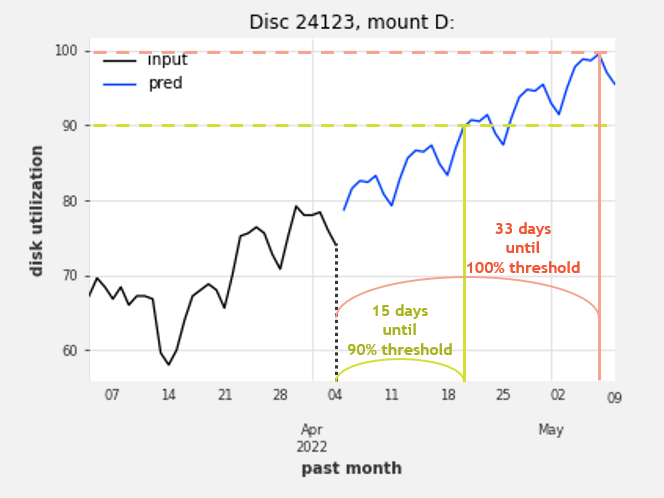



## Importing Libraries

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path
import os
import math
import time

from sandbox_src.utils.config import load_config
from sandbox_src.preprocessing.preprocessing import DataPreprocess
from sandbox_src.feature_engineering.feature_engineering import ClusterFeatureEngine
from sandbox_src.model_development.model_development import ModelDevelopment

from darts.models import (
    AutoARIMA,
    LightGBMModel
)
import random
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics.metrics import mae, mse

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

[2022-05-10 16:32:16,047] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[prophet] or u8darts[all].


## Importing Data

<b>Dataset Explanation:</b>
The dataset includes disk utilization data for 30 different disks each of which has 90 days of data.


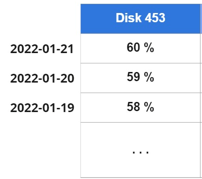


In [17]:
# Import data
df_disks = pd.read_csv("sandbox_synthetic_train_data_v2.csv", parse_dates=["Date"])
# Set "Date" column as index
df_disks.set_index(["Date"], inplace=True)

### Let's have a look at our dataset

In [18]:
df_disks.head()

,Disk_1,Disk_2,Disk_3,Disk_4,Disk_5,Disk_6,Disk_7,Disk_8,Disk_9,Disk_10,...,Disk_1199,Disk_1200,Disk_1201,Disk_1202,Disk_1203,Disk_1204,Disk_1205,Disk_1206,Disk_1207,Disk_1208
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,26.000000,32.000000,23.000000,11.000000,18.000000,27.000000,13.000000,23.000000,30.000000,29.000000,...,32.000000,42.000000,40.000000,31.000000,20.000000,40.000000,40.000000,30.000000,39.000000,45.000000
2022-01-02,25.164229,32.934208,23.767508,11.413182,18.114692,27.635833,12.620166,22.151559,30.924577,28.686095,...,31.863012,42.299517,40.978051,31.883150,20.916240,39.011968,39.411968,31.050904,37.260928,44.621817
2022-01-03,24.301035,33.159261,24.542706,10.544558,18.989186,26.954619,12.831877,22.314634,30.473023,29.398625,...,32.186121,42.658744,40.110016,31.024494,20.630688,39.695189,40.495189,31.293997,38.608082,45.873891
2022-01-04,24.786593,33.391173,25.155790,11.357127,19.584818,26.241311,12.633970,23.286229,30.598197,28.652404,...,33.176839,42.188093,40.967830,30.798523,19.915371,40.893997,42.093997,30.688369,38.454251,44.179465
2022-01-05,25.353681,33.165377,26.023170,11.415367,19.799340,27.224058,12.925220,22.354024,30.833053,29.478356,...,33.213634,42.013921,40.610700,30.842225,20.573071,40.580611,42.180611,29.998847,37.733062,46.180240


In [19]:
df_disks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2022-01-01 to 2022-03-31
Columns: 1208 entries, Disk_1 to Disk_1208
dtypes: float64(1170), object(38)
memory usage: 850.1+ KB


In [20]:
df_disks.describe()

,Disk_1,Disk_2,Disk_3,Disk_4,Disk_5,Disk_6,Disk_7,Disk_8,Disk_9,Disk_10,...,Disk_1199,Disk_1200,Disk_1201,Disk_1202,Disk_1203,Disk_1204,Disk_1205,Disk_1206,Disk_1207,Disk_1208
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,32.258671,40.506934,31.051981,21.403180,29.881730,35.866176,16.824788,26.524704,36.179535,37.795248,...,44.155076,46.661650,45.654695,38.357968,29.378978,39.997674,57.797674,38.921360,42.453548,47.218367
std,3.739942,4.319320,5.602621,4.995122,6.233065,5.659363,2.640752,5.012057,3.112326,5.251806,...,6.519701,5.190393,3.648833,3.323513,6.054638,0.707378,10.492001,5.275495,2.695872,1.481271
min,24.301035,32.000000,23.000000,10.544558,18.000000,26.241311,11.937338,21.181768,30.000000,28.652404,...,31.863012,41.655944,40.000000,30.798523,19.915371,39.000240,39.411968,29.998847,37.260928,44.179465
25%,30.545156,36.807033,26.024315,19.694486,24.283722,31.604439,15.060343,22.362711,33.642585,31.709905,...,38.588898,42.774776,42.929368,36.416742,24.968578,39.293084,49.057554,34.395983,40.226638,46.162315
50%,32.469513,41.245721,31.193033,22.360827,30.329500,34.698746,16.983486,23.893563,36.612654,40.031246,...,45.709668,44.167101,44.769979,39.155532,26.587768,39.977818,57.880638,38.731229,42.492046,47.199075
75%,35.191337,43.570651,34.133233,25.219773,36.013118,40.536954,18.168698,31.116028,38.842315,41.586650,...,48.055290,50.116395,48.538556,40.409262,36.058432,40.674953,66.677264,43.547954,44.739258,48.361303
max,39.268006,48.895881,42.928591,28.408128,39.356191,46.027079,22.087581,36.772415,42.073464,45.170174,...,55.373061,60.906533,54.527456,45.311827,39.923761,40.999752,76.073415,48.599748,47.737974,50.345524


## Initialize Class Instances

In [21]:
# Load config
config = load_config('config.yml')

In [22]:
# Create necessary class instances
preprocessor = DataPreprocess()
feature_engine = ClusterFeatureEngine(config=config)
model_development = ModelDevelopment(config=config)

## Model Mapping

We would not want complexity of having a seperate model for each disk, so we used a limited model pool. Hence, this model mapping process is implemented to match disks with their best suited time series model for daily forecasts. To do that, each disk is examined with each time series model from the pool based on their performance metrics. But, this is an expensive process both in terms of computation and time complexity.

### Let's first see the synchronous Python implementation with only 2 disks

In [23]:
df_disks_w_2disks = df_disks.iloc[:, :2]
df_disks_w_2disks

,Disk_1,Disk_2
Date,,
2022-01-01,26.000000,32.000000
2022-01-02,25.164229,32.934208
2022-01-03,24.301035,33.159261
2022-01-04,24.786593,33.391173
2022-01-05,25.353681,33.165377
...,...,...
2022-03-27,37.821327,47.794968
2022-03-28,38.337808,48.117277
2022-03-29,37.448022,48.800963


In [10]:
# Compute execution time for the model mapping process
start_time = time.time()
errors_df = feature_engine.cluster_disks(df_disks_w_2disks)
elapsed_time = time.time() - start_time

print(f'The total elapsed time for model mapping process with 2 disks is: {elapsed_time:.2f} seconds')

The total elapsed time for model mapping process with 2 disks is: 75.29 seconds


In [11]:
# Output of the model mapping process
errors_df

,diskname,lgbm_7_model_mae_mean,lgbm_7_model_mae_std,lgbm_30_model_mae_mean,lgbm_30_model_mae_std,arima_30_model_mae_mean,arima_30_model_mae_std
0,Disk_1,1.838813,0.975323,2.640144,0.636033,2.798495,0.823476
1,Disk_2,2.373196,0.539590,2.422386,0.144601,1.266411,0.493651


### Now, let's match disks with their models based on their performance metrics

In [12]:
model_mapping_df = feature_engine.get_model_selection(errors_df)

In [13]:
model_mapping_df

,DiskName,CurrentAvgMae,CurrentStdMae,ModelId
0,Disk_1,2.64014,0.63603,3
1,Disk_2,2.42239,0.14460,3


### Since we have matched our disks with their best suited time series model, we can make predictions now 

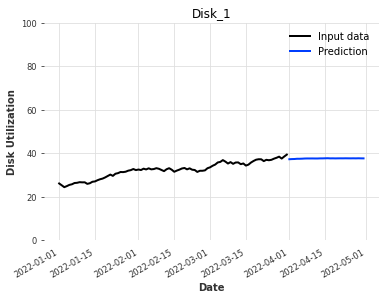

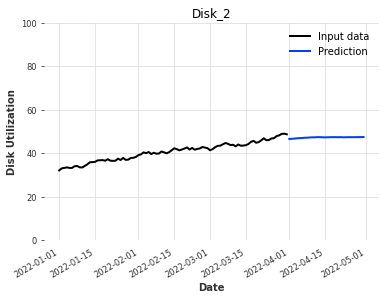

In [14]:
predictions_df = pd.DataFrame()

#Make predictions by iterating on each column from main df
for i in df_disks_w_2disks.columns:
    
    series = df_disks_w_2disks.loc[:, i]
    model_id = model_mapping_df[model_mapping_df["DiskName"] == i]["ModelId"].iloc[0]

    if model_id == 1:
        series = preprocessor.convert_series2darts(series)
        prediction = model_development.predict_arima(series)
    elif model_id == 2:
        series = preprocessor.convert_series2darts(series.iloc[-14:])
        prediction = model_development.predict_lgbm_14(series)
    elif model_id == 3:
        series = preprocessor.convert_series2darts(series)
        prediction = model_development.predict_lgbm_30(series)
    elif model_id == 4:
        prophet_df = preprocessor.convert_series2prophetdf(series.iloc[-7:])
        prediction = model_development.predict_prophet(prophet_df)
    else:
        prophet_df = preprocessor.convert_series2prophetdf(series)
        prediction = model_development.predict_prophet(prophet_df)
        
    predictions_df[i] = prediction.pd_dataframe()

    #Plot forecasts
    series.plot()
    prediction.plot()
    plt.legend(['Input data', 'Prediction'])
    plt.ylim(0,100)
    plt.xlabel('Date')
    plt.ylabel('Disk Utilization')
    plt.title(i)
    plt.show()
    

### Let's evaluate our results with the test set

In [24]:
#Import test data
test_df = pd.read_csv("sandbox_synthetic_test_data_v2.csv", parse_dates = ["Date"])
test_df.set_index("Date", inplace = True)

In [25]:
# Filter first 2 disks as we did in the training set
test_df = test_df.iloc[:, :2]

In [26]:
#Evaluate results using Mean Absolute Error

for i in test_df.columns:
    print("Error on disk {}: {}".format(i, mean_absolute_error(test_df[i], predictions_df[i])))

NameError: name 'predictions_df' is not defined

# Ray

### What is Ray?
Ray is an open-source distributed technology that makes scaling Python applications a more intuitive and simpler process. It offers several libraries for scalable model training, model serving, hyper-parameter tuning, reinforcement learning and scaling any Python application. For this project, we used Ray Core which is the core library that other Ray libraries were built on top of. It is used to convert any Python application to a distributed setup.

Ray official website: www.ray.io 

Ray documentation: https://docs.ray.io/en/latest/

### A simple tutorial

We will demonstrate the usage of Ray with the simplest use case where tasks mimic 2.5 seconds of computation.

In [27]:
import time

def task(id):
    time.sleep(2.5)   
    print(f"Done: {id}")
    
    return

In [28]:
start = time.time()
[task(i+1) for i in range(4)]
print(f"Elapsed time: {time.time()-start}")

Done: 1
Done: 2
Done: 3
Done: 4
Elapsed time: 10.029294729232788




By placing a ray decorator on top of a function, we convert a function to a Ray task. We can call Ray tasks in an asynchronous way. Ray is going to handle the scheduling and resource management. Under the hood, it will utilize the available computational resources.

### Let's convert our function into a Ray task

In [29]:
import ray

ray.init()

@ray.remote
def ray_task(id):
    time.sleep(2.5)
    print(f"Done: {id}")
    
    return

In order to call many Ray tasks in an asynchronous way, we use remote() method at the end of the function. As soon as we call the remote() method, the program flow will proceed asynchronously but under the hood, Ray starts the execution of Ray tasks. It will return us a feature id which is the representation of the eventual result.

In [30]:
start = time.time()
future_id_list = [ray_task.remote(i+1) for i in range(4)]
print(f'The first future id: {future_id_list[0]}')
ray.get(future_id_list)
print(f"\nElapsed time: {time.time()-start}")
ray.shutdown()

The first future id: ObjectRef(a67dc375e60ddd1affffffffffffffffffffffff0100000001000000)

Elapsed time: 2.5457019805908203


### Note: Check the elapsed time for Ray and compare it with the elapsed time of the above function without Ray

### A Ray Cluster

While Ray can distribute the workload among the available cores on a single machine, it can also the handle the distribution of the workload to a Ray cluster, either on-prem or on cloud. This gives an enourmous speed and unlimited scaling option for your workload.

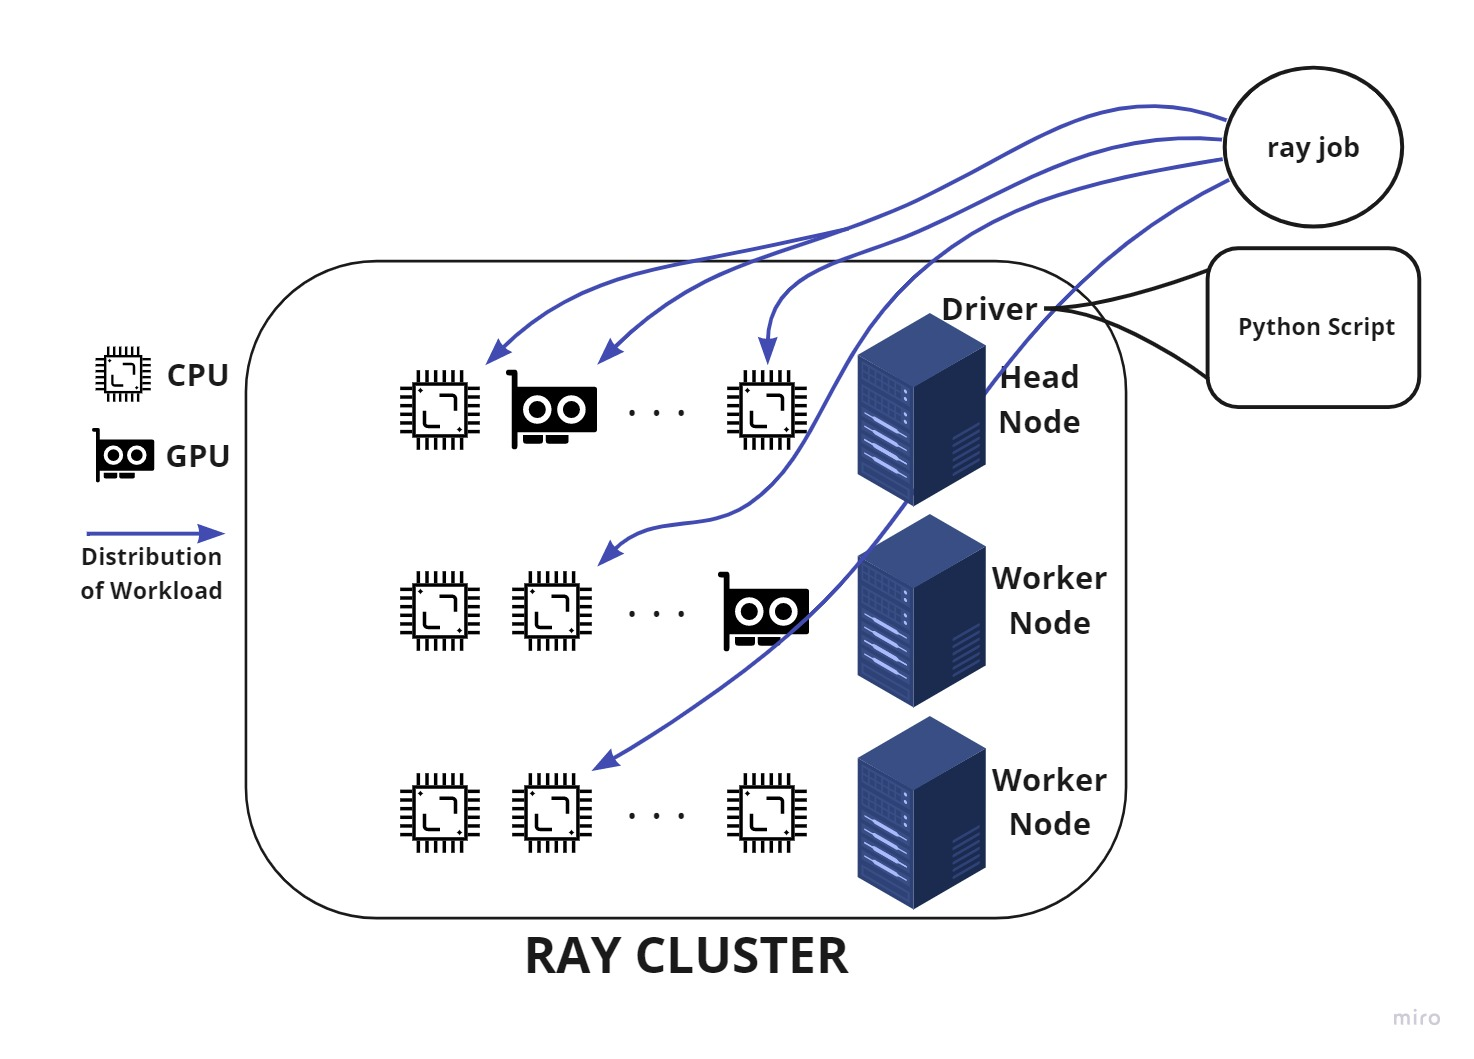

Note: We do not have on-prem Ray cluster for this demonstration (But we have cloud!). We will work with a single node Ray session which will use all the cores available unless it is changed. 

# Solving the bussiness problem with Ray

### Let's pick a number between 5 and 15 in the below cell for the number of disks to be mapped with Ray implementation now

In [31]:
#Please specify the number of disks for this demo
#Choose between 5 to 15 and press Enter
ray_nb_of_disks = int(input())

#Filter columns based on the given input
df_disks_w_ray = df_disks.iloc[:, :ray_nb_of_disks]

1


In [32]:
import ray

In [33]:
ray.init(log_to_driver=False)

{'node_ip_address': '10.91.91.154',
 'raylet_ip_address': '10.91.91.154',
 'redis_address': '10.91.91.154:6379',
 'object_store_address': 'tcp://127.0.0.1:65280',
 'raylet_socket_name': 'tcp://127.0.0.1:62020',
 'webui_url': None,
 'session_dir': 'C:\\Users\\02485354\\AppData\\Local\\Temp\\ray\\session_2022-05-10_16-33-39_482170_8100',
 'metrics_export_port': 64581,
 'node_id': '0c1e77c4a764208c93b9ab7a04c08e9debf191871ed4bd0c93c1fc67'}

In [34]:
start_time = time.time()

futures = []
for col in df_disks_w_ray.columns:
    futures.append(feature_engine.cluster_disk_task.remote(df_disks_w_ray[col]))
ray.get(futures)

ray_elapsed_time = time.time() - start_time
print(f'The total elapsed time for model mapping process with {ray_nb_of_disks} disks and Ray is: {ray_elapsed_time:.2f} seconds')

ray.shutdown()

The total elapsed time for model mapping process with 1 disks and Ray is: 32.59 seconds


<b>Note: </b>This was a performance illustration of Ray. So we did not save the results into a variable. 

## Performance Comparison

In [35]:
print(f"Elapsed time for synchronous Python with 2 disks = {elapsed_time:.2f} -> Throughput = {2/elapsed_time:.2f} disk/sec")
print(f"Elapsed time for Ray with {ray_nb_of_disks} disks = {ray_elapsed_time:.2f} -> Throughput = {ray_nb_of_disks/ray_elapsed_time:.2f} disk/sec")

NameError: name 'elapsed_time' is not defined

* Note that as the provision of computational resources increase, this performance gap is going to be more significant.

# Anyscale

### What is Anyscale?

"Anyscale is a fully-managed Ray offering, from the creators of Ray. It accelerates building, scaling and deploying AI applications on Ray by eliminating the need to build and manage complex infrastructure." - Anyscale.com

https://www.anyscale.com/

We do not need to concern about the infrastructure of our Ray applications, since Anyscale handles the provision.

### How to use it?

To connect our Ray application to our Anyscale cluster in the cloud, we just need to add a keyword to our ray.init() function.

For the local, it was: 
<b> ray.init() </b>


For the cloud, it is:
<b> ray.init("anyscale://disk-demo-cluster") </b>

Once you do that, your Ray application will connect to the cluster and all the work you give to Ray will be conveyed to cluster.

### Setting up the cluster



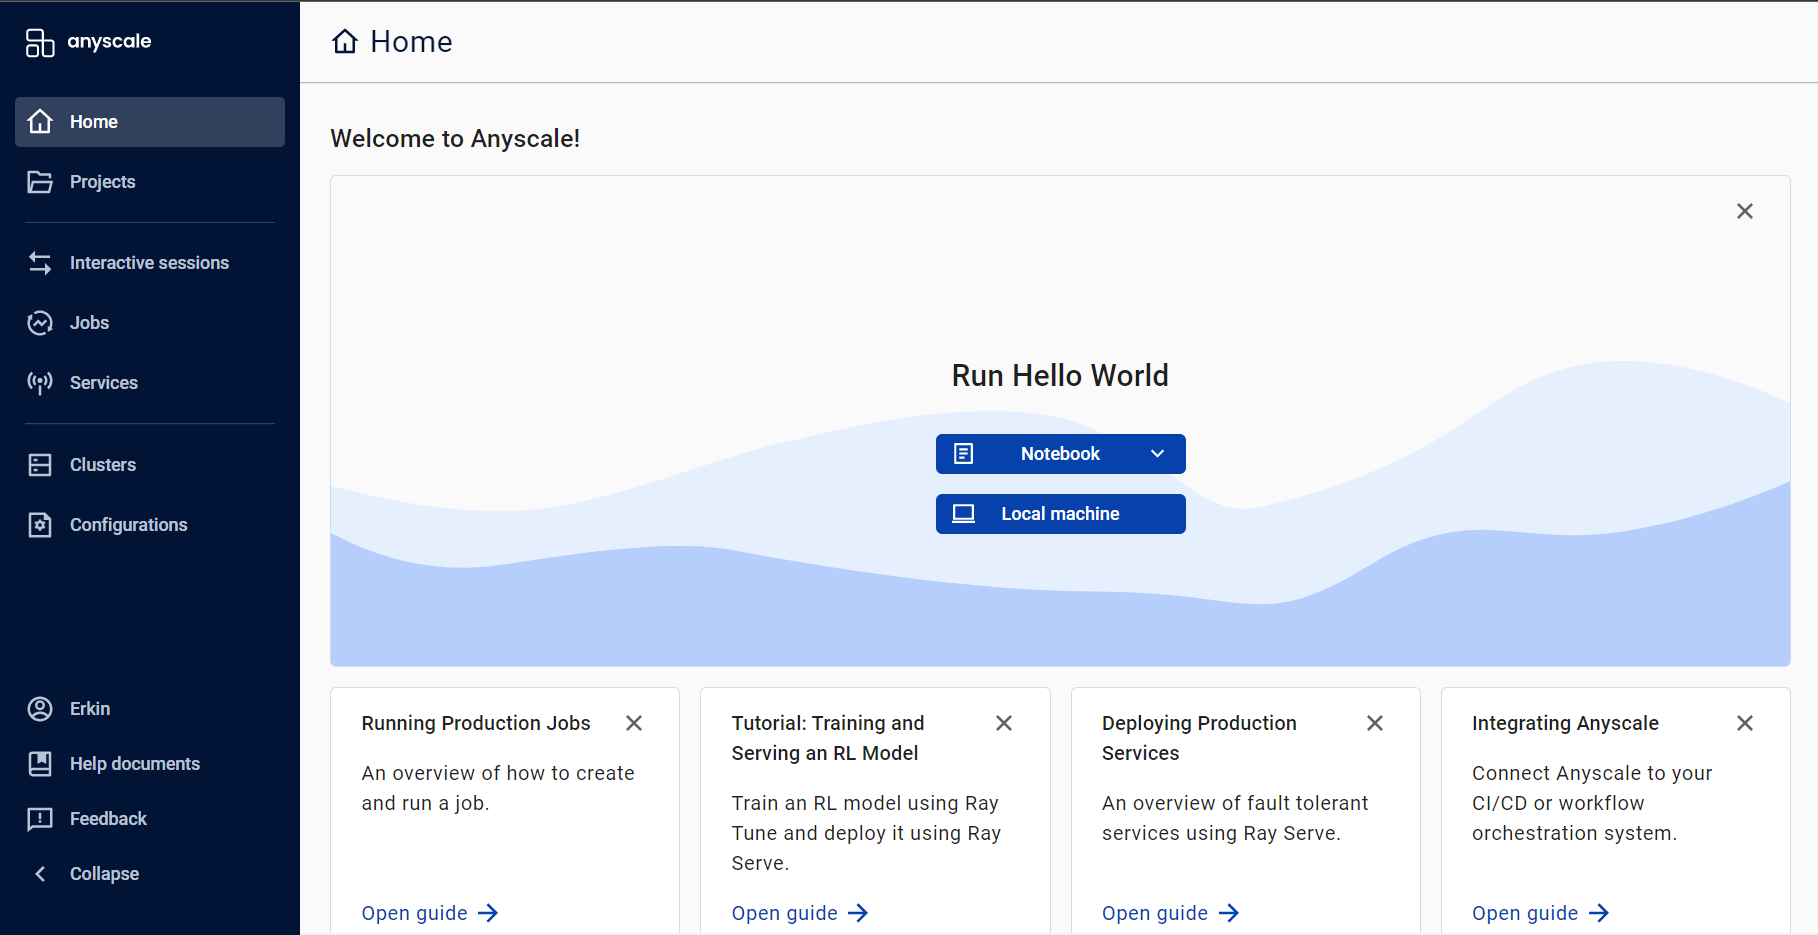

Above is the homepage for Anyscale. You can work on your cluster from the left navigation panel.

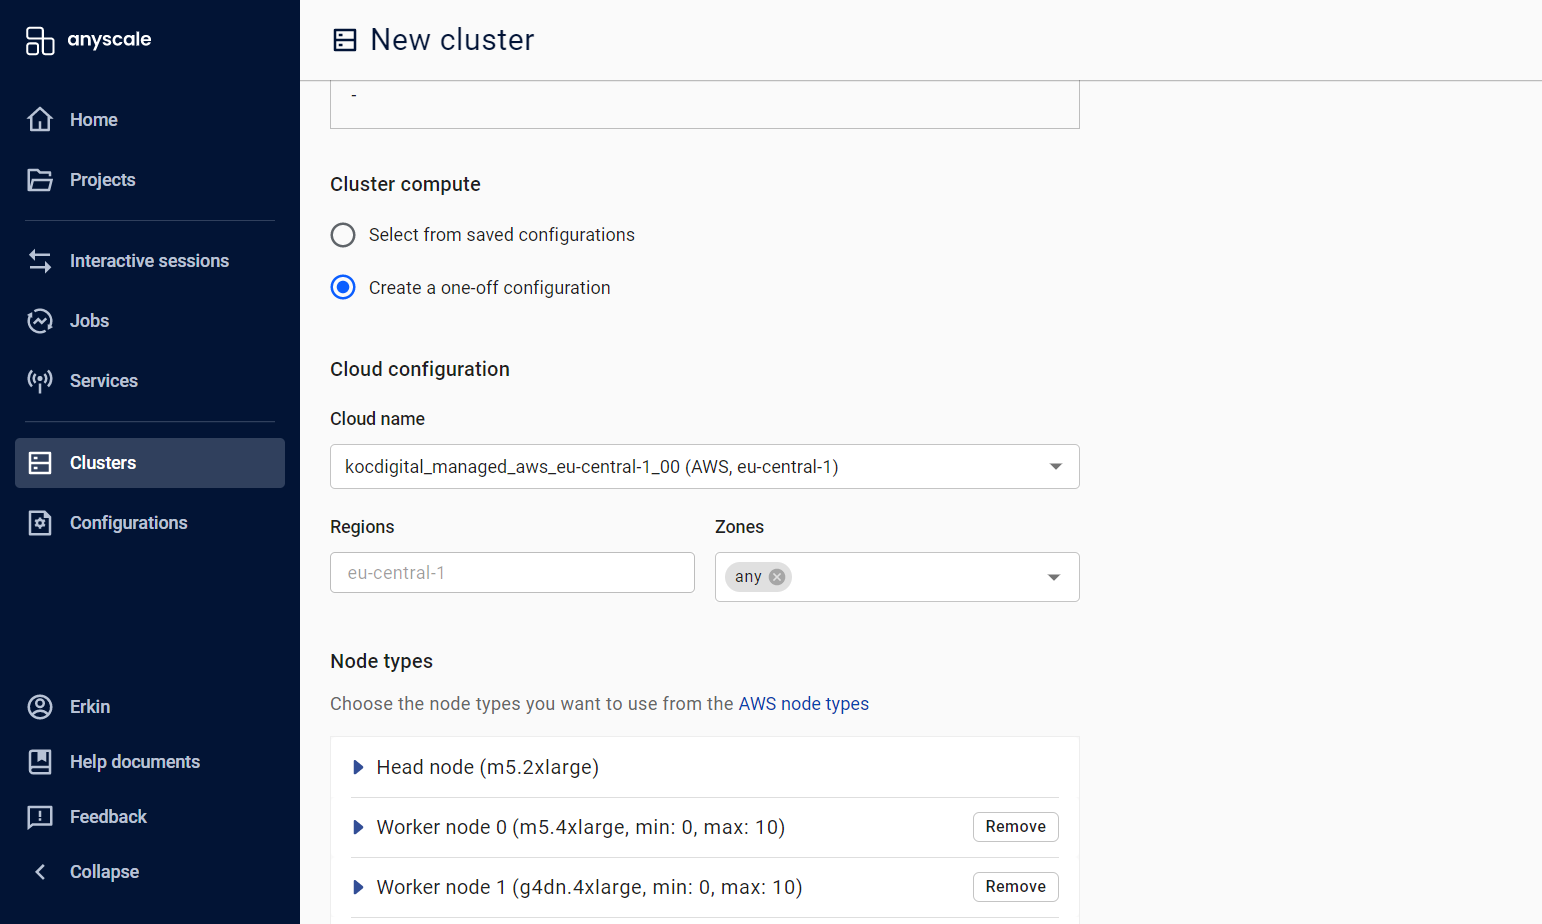

Anyscale handles AWS resources for us. We can select an instance type from AWS' rich EC2 pool.

Once this is done, we can connect this cluster to our Ray application using the name of the cluster.

In [20]:
ray.init("anyscale://disk-demo-cluster")

RuntimeError: Module: anyscale does not exist.
This module was parsed from Address: anyscale://disk-demo-cluster

Let's check our cluster resources.

In [ ]:
print(f"Cluster resources: {ray.cluster_resources()}")
ray.shutdown()

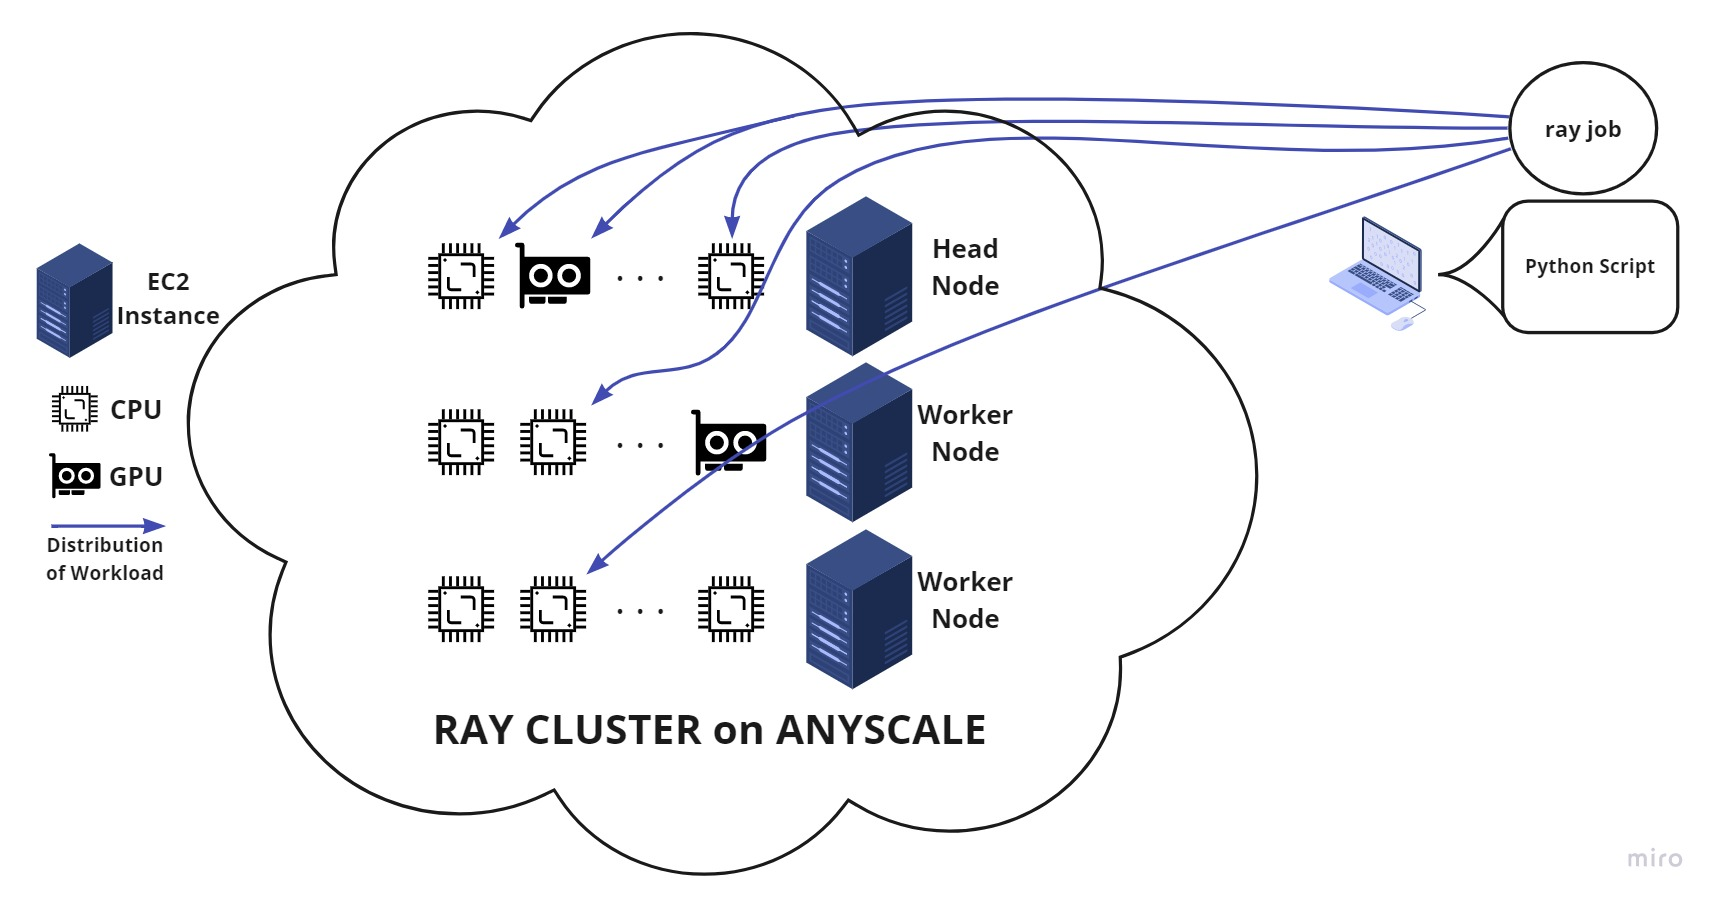

### Runtime Environment

One problem with distributed computing is dealing with dependencies either libraries or some other files that are needed for the runtime. Ray has a feature called runtime environment for injecting the dependencies (e.g. Python modules, imported scripts) to the Ray cluster.

We have some libraries installed and some imported scripts that Ray is not aware of their locations for our bussiness problem. Now, let's initialize our runtime environment.

In [2]:
runtime_env = {"py_modules":["sandbox_src"], "pip": ["setuptools==59.5.0", "u8darts[pmdarima]", 
                                              "pandas", "numpy", "scikit-learn"]}

In [3]:
ray.init("anyscale://disk-demo-cluster", runtime_env=runtime_env, log_to_driver=False)

Authenticating


Loaded Anyscale authentication token from ~/.anyscale/credentials.json.



Parsing Ray Client arguments

Choosing a project


[Warning] No working_dir specified! Files will only be uploaded to the cluster if a working_dir is provided or a project is detected. In the future, files will only be uploaded if working_dir is provided. To ensure files continue being imported going forward, set the working_dir in your runtime environment. See https://docs.ray.io/en/latest/handling-dependencies.html#runtime-environments.
Finished parsing arguments.
No project defined. Continuing without a project.



Preparing the cluster


Cluster disk-demo-cluster exists but not running. This cluster will be restarted.
Restarting cluster disk-demo-cluster:
  cluster id:                   ses_WXnTmEA1DdKA8ABVP5dXn3fB
  cluster environment:          DEFAULT_APP_CONFIG_ID_1.10.0_py39:1
  cluster environment id:       anyscaleray1100-py39
  cluster compute:              disk-demo-cluster-conf
  cluster compute id:           cpt_QJer7FLTwvB3qqunvx81SS3Y
  link:                         https://console.anyscale.com/projects/prj_fRZuN8Y1k7AkpcvkYhAEmc66/clusters/ses_WXnTmEA1DdKA8ABVP5dXn3fB
Waiting for cluster disk-demo-cluster to start. This may take a few minutes


KeyboardInterrupt: 

# Immerse Scaling with Anyscale for Solving the Business Problem

### Now you pick 200 disks (or more!)

#### * We have a dataset of 1200 disks for this demo.

In [58]:
#Please specify the number of disks for this demo
anyscale_nb_of_disks = int(input())

#Filter columns based on the given input
df_disks_w_anyscale = df_disks.iloc[:, :anyscale_nb_of_disks]

15


In [67]:
start_time = time.time()

futures = []
for col in df_disks_w_anyscale.columns:
    futures.append(feature_engine.cluster_disk_task.remote(df_disks_w_anyscale[col]))
ray.get(futures)

anyscale_elapsed_time = time.time() - start_time
print(f'The total elapsed time for model mapping process with {anyscale_nb_of_disks} disks and Ray is: {anyscale_elapsed_time:.2f} seconds')

ray.shutdown()

RayTaskError(AttributeError): [36mray::cluster_disk_task()[39m (pid=2349323, ip=172.18.228.122)
  File "/data/scanalytics/KS_DiskKapasiteTahminleme/sandbox_src/feature_engineering/feature_engineering.py", line 259, in cluster_disk_task
    errors_df = self.create_model_error_df(diskname, lgbm_7_model_mae_mean, lgbm_7_model_mae_std, lgbm_30_model_mae_mean, lgbm_30_model_mae_std, arima_30_model_mae_mean, arima_30_model_mae_std)
AttributeError: 'int' object has no attribute 'create_model_error_df'

2022-04-14 15:52:46,947	ERROR worker.py:85 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::cluster_disk_task() (pid=2349325, ip=172.18.228.122)
  File "/data/scanalytics/KS_DiskKapasiteTahminleme/sandbox_src/feature_engineering/feature_engineering.py", line 259, in cluster_disk_task
    errors_df = self.create_model_error_df(diskname, lgbm_7_model_mae_mean, lgbm_7_model_mae_std, lgbm_30_model_mae_mean, lgbm_30_model_mae_std, arima_30_model_mae_mean, arima_30_model_mae_std)
AttributeError: 'int' object has no attribute 'create_model_error_df'
2022-04-14 15:52:46,950	ERROR worker.py:85 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::cluster_disk_task() (pid=2349316, ip=172.18.228.122)
  File "/data/scanalytics/KS_DiskKapasiteTahminleme/sandbox_src/feature_engineering/feature_engineering.py", line 259, in cluster_disk_task
    errors_df = self.create_model_error_df(diskname, lgbm_7_model_mae_mean, lgbm_7_model_mae_std, lgbm_30_model_mae_mean, 

## Performance Comparison

In [ ]:
print(f"Elapsed time for synchronous Python with 2 disks = {elapsed_time:.2f} -> Throughput = {2/elapsed_time:.2f}")
print(f"Elapsed time for Ray with {ray_nb_of_disks} disks = {ray_elapsed_time:.2f} -> Throughput = {ray_nb_of_disks/ray_elapsed_time:.2f}")
print(f"Elapsed time for Anyscale with {anyscale_nb_of_disks} disks = {anyscale_elapsed_time:.2f} -> Throughput = {anyscale_nb_of_disks/anyscale_elapsed_time:.2f}")